In [45]:
import pandas as pd 
import numpy as np
import seaborn as sns


#!pip install prophet
from prophet import Prophet 
import matplotlib .pyplot as plt
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

# 1) Data Onboarding and initial checking

In [23]:
sales_df = pd.read_csv('../archive/Processed Data/processed_transactions_data.csv')

In [24]:
sales_df.head()

,Transaction ID,Customer ID,Transaction Date,Prod Subcat Code,Prod Cat Code,Qty,Rate,Tax,Total Amt,Store Type,Net_Sales
0,29258453508,270384,2014-02-20,5,3,5,1497,785.925,8270.925,e-Shop,7485
1,25455265351,267750,2014-02-20,12,6,3,1360,428.400,4508.400,e-Shop,4080
2,1571002198,275023,2014-02-20,6,5,4,587,246.540,2594.540,e-Shop,2348
3,36554696014,269345,2014-02-20,3,5,3,1253,394.695,4153.695,e-Shop,3759
4,56814940239,268799,2014-02-20,7,5,5,368,193.200,2033.200,e-Shop,1840


In [7]:
df.shape

(20876, 11)

# 2) Data Preprocessing

In [25]:
#convert date to datetime format 
sales_df['Transaction Date'] = pd.to_datetime(sales_df['Transaction Date'],dayfirst = True)  

In [26]:
#Take only needed features [Date and Sales], Quantity has taken for checking each day sales quantity not for model 
sales_df = sales_df[['Transaction Date','Total Amt', 'Qty']] 
sales_df.columns = ['ds','y','Qty'] 
sales_df

,ds,y,Qty
0,2014-02-20,8270.925,5
1,2014-02-20,4508.400,3
2,2014-02-20,2594.540,4
3,2014-02-20,4153.695,3
4,2014-02-20,2033.200,5
...,...,...,...
20871,2011-01-25,1396.720,1
20872,2011-01-25,748.085,1
20873,2011-01-25,4649.840,4
20874,2011-01-25,3785.730,3


In [27]:
#Make a group by Date, [unique date in each row] 
sales_df = sales_df.groupby('ds').sum()

In [28]:
sales_df

,y,Qty
ds,,
2011-01-25,48957.025,56
2011-01-26,62045.750,67
2011-01-27,30886.960,45
2011-01-28,39730.275,39
2011-01-29,42027.570,59
...,...,...
2014-02-16,47419.970,53
2014-02-17,29334.435,34
2014-02-18,37508.120,42


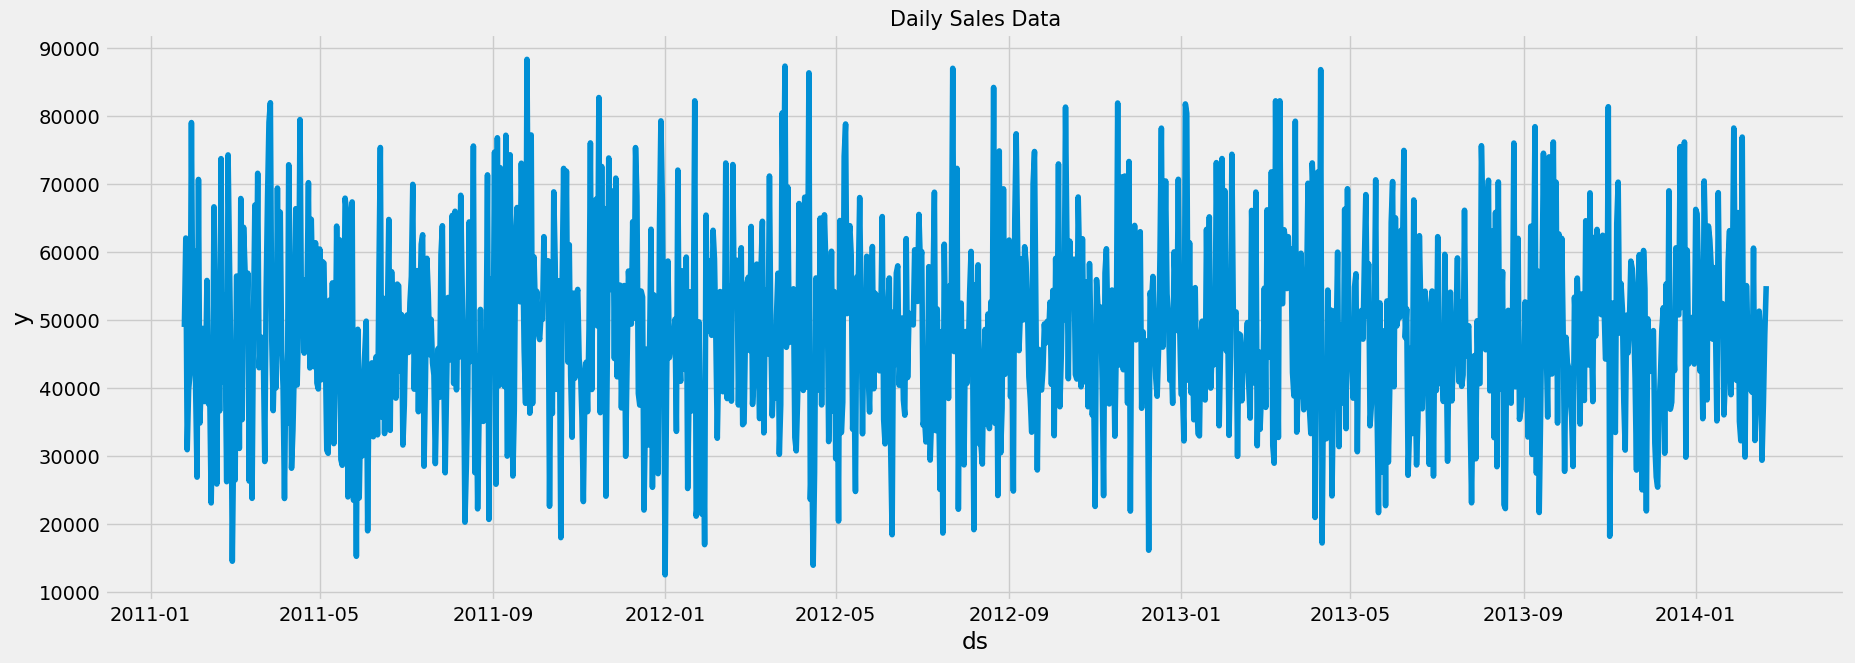

In [29]:
## Plot the Time series data 

fig, ax = plt.subplots(figsize=(20,7))
a = sns.lineplot(x="ds", y="y", data=sales_df)
a.set_title("Daily Sales Data",fontsize=15) 
plt.show()



In [36]:
# creating new features to help with the Time Series Analysis

sales_df["Year"] = sales_df.index.year
sales_df["Quarter"] = sales_df.index.quarter
sales_df["Month"] = sales_df.index.month
sales_df["Week"] = sales_df.index.week
sales_df["Weekday"] = sales_df.index.weekday
sales_df["Day"] = sales_df.index.day
sales_df["Dayofyear"] = sales_df.index.dayofyear
sales_df["Date"] = pd.DatetimeIndex(sales_df.index).date

# checking new features
sales_df.head()

,y,Qty,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date
ds,,,,,,,,,,
2011-01-25,48957.025,56,2011,1,1,4,1,25,25,2011-01-25
2011-01-26,62045.750,67,2011,1,1,4,2,26,26,2011-01-26
2011-01-27,30886.960,45,2011,1,1,4,3,27,27,2011-01-27
2011-01-28,39730.275,39,2011,1,1,4,4,28,28,2011-01-28
2011-01-29,42027.570,59,2011,1,1,4,5,29,29,2011-01-29


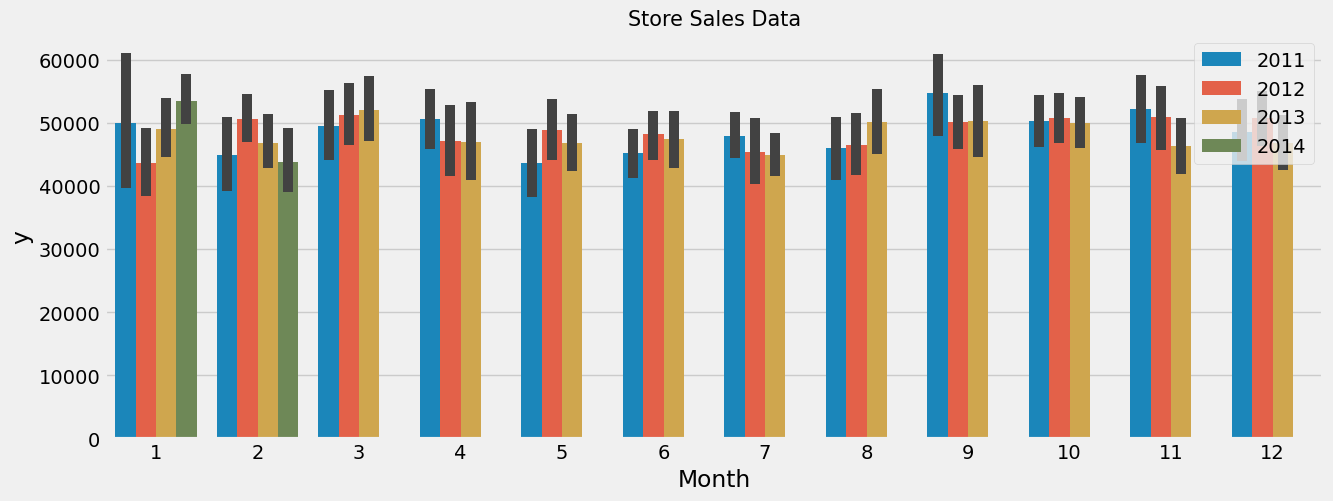

In [38]:
#Let's see the sales distibution by month and year

fig, ax = plt.subplots(figsize=(14,5))
palette = sns.color_palette("mako_r", 4)
a = sns.barplot(x="Month", y="y",hue = 'Year',data=sales_df)
a.set_title("Store Sales Data",fontsize=15)
plt.legend(loc='upper right') 
plt.show()

we can see that the monthly sales distributions are quite similar and from this we can't conclude anything so, let's look at deeper in the next plots 

Text(0.5, 1.0, 'Total Sales received By year')

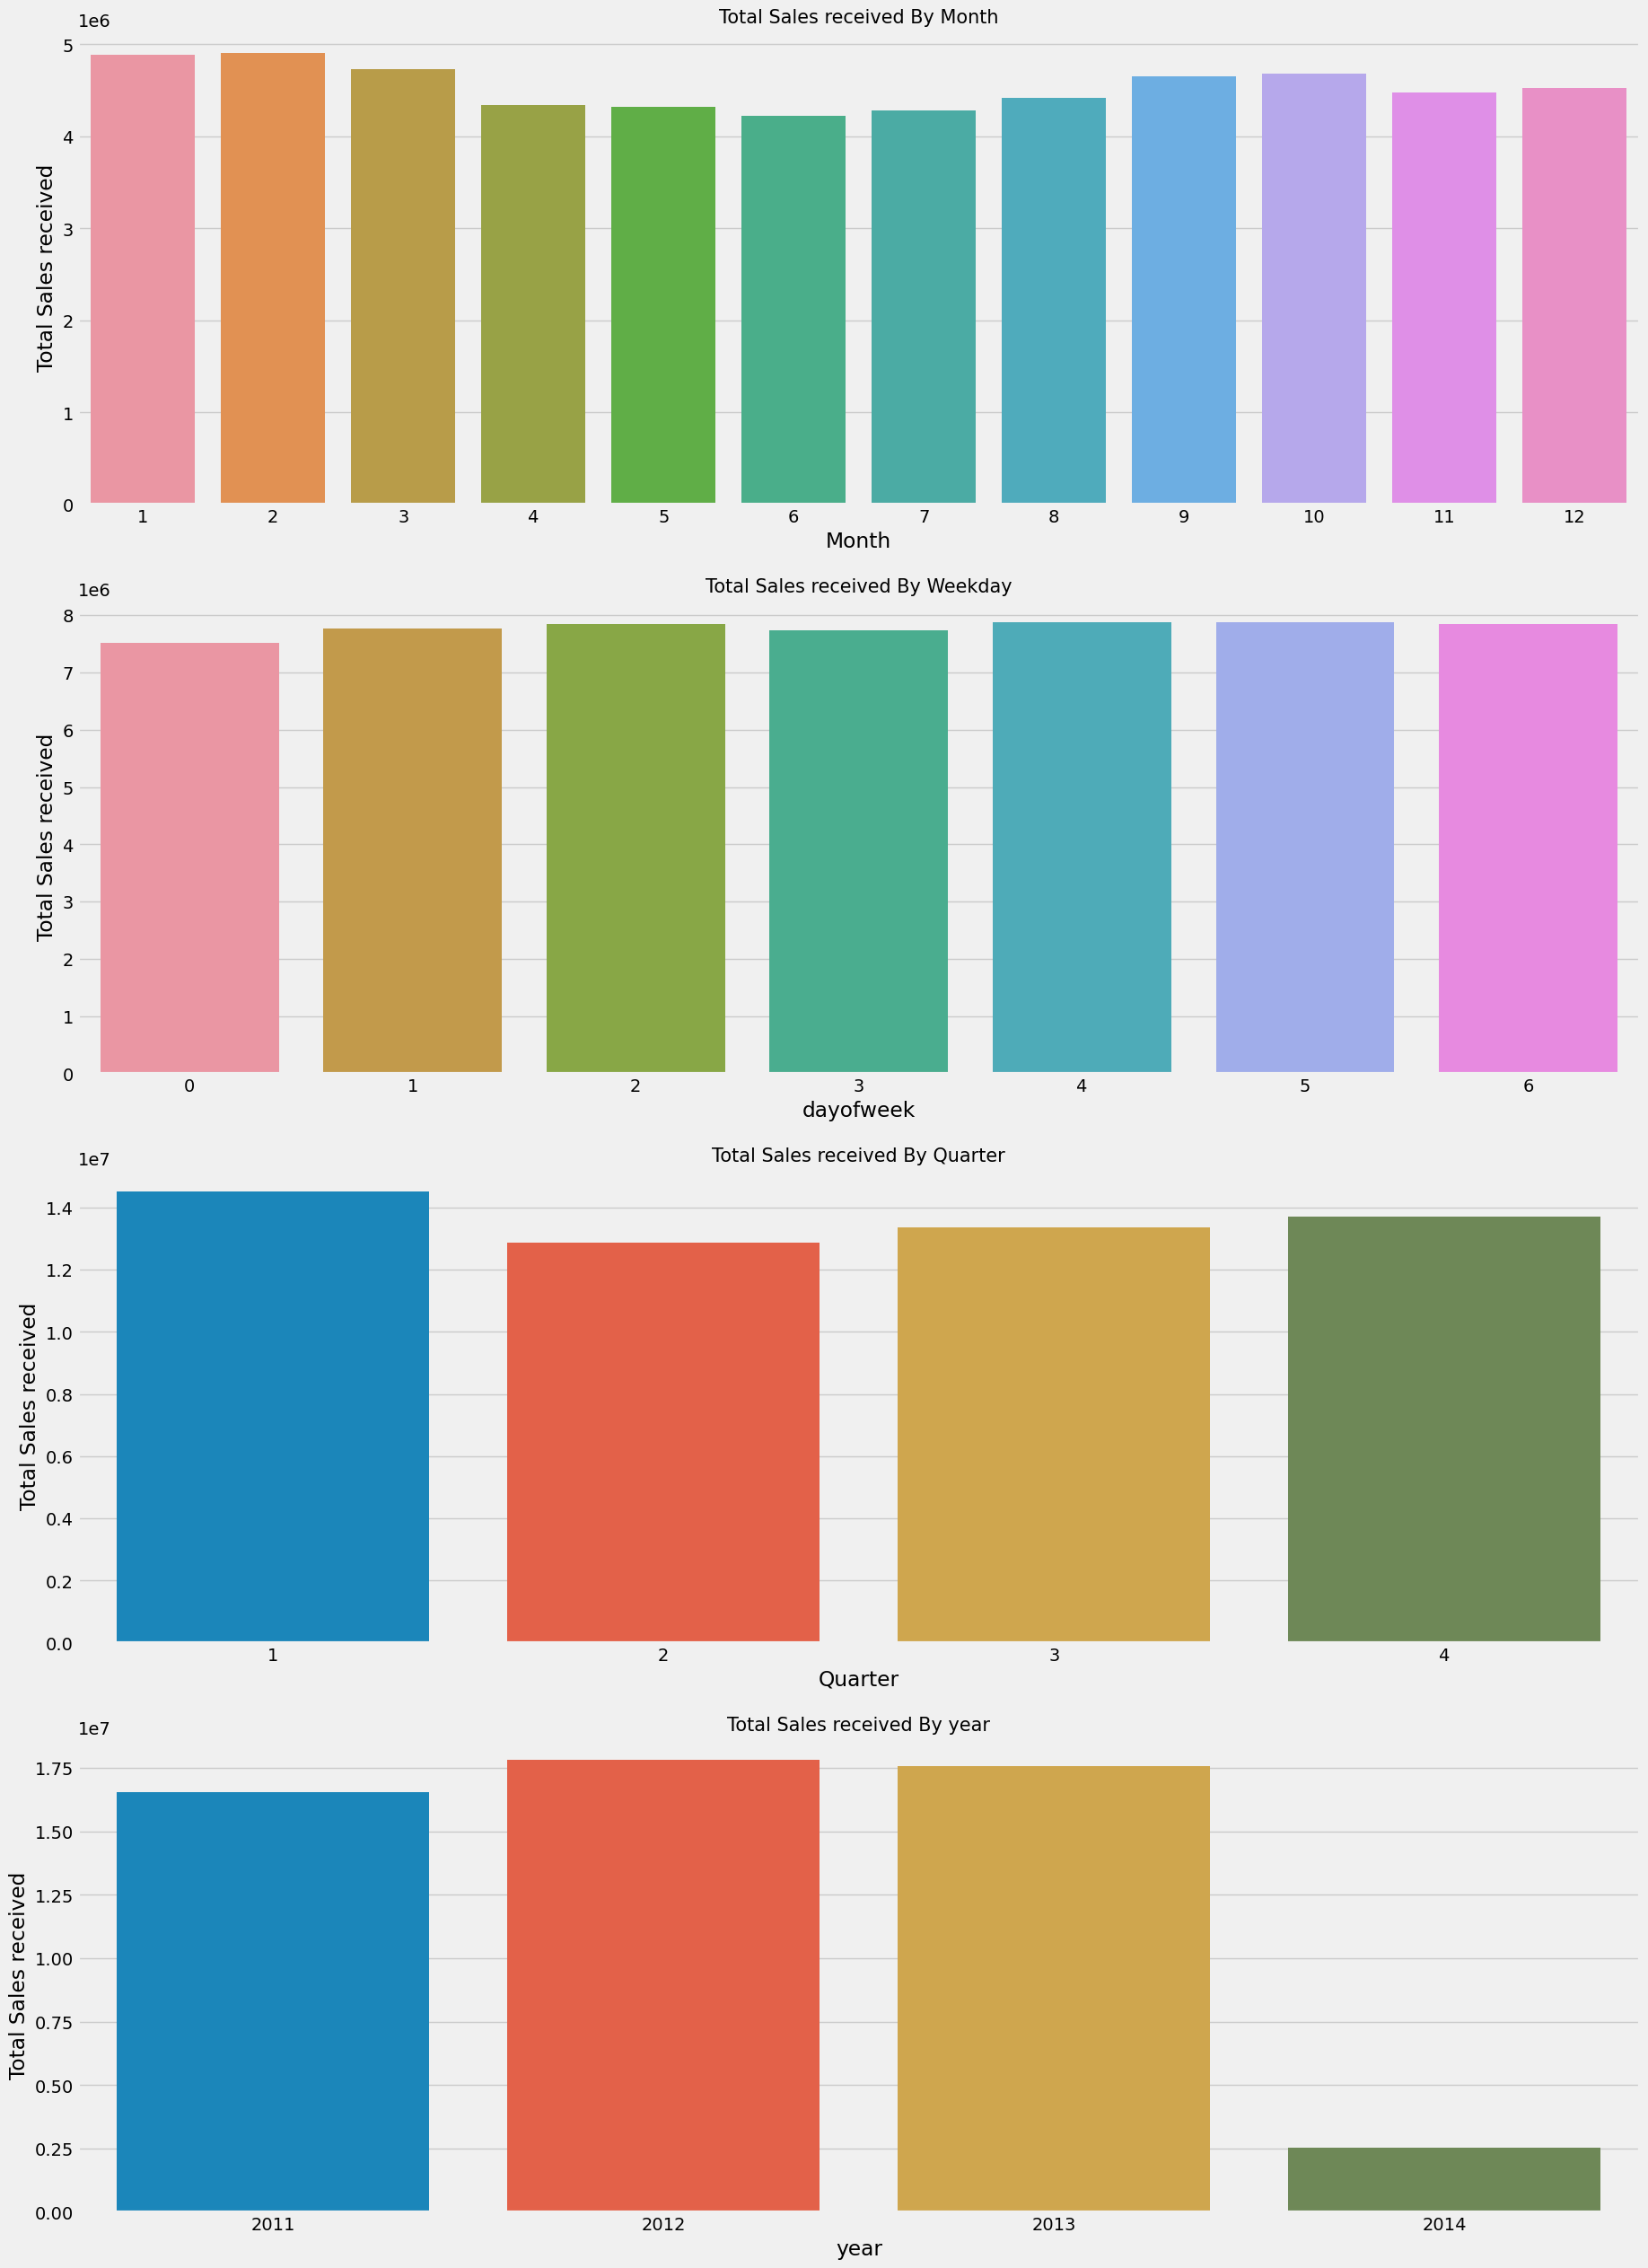

In [39]:
#Let's see total sales by monthly, weekly, quarterly and yearly

fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(20,30)

monthAggregated = pd.DataFrame(sales_df.groupby("Month")["y"].sum()).reset_index().sort_values('y')
sns.barplot(data=monthAggregated,x="Month",y="y",ax=ax1)
ax1.set(xlabel='Month', ylabel='Total Sales received')
ax1.set_title("Total Sales received By Month",fontsize=15)

weekAggregated = pd.DataFrame(sales_df.groupby("Weekday")["y"].sum()).reset_index().sort_values('y')
sns.barplot(data=weekAggregated,x="Weekday",y="y",ax=ax2)
ax2.set(xlabel='dayofweek', ylabel='Total Sales received')
ax2.set_title("Total Sales received By Weekday",fontsize=15)

quarterAggregated = pd.DataFrame(sales_df.groupby("Quarter")["y"].sum()).reset_index().sort_values('y')
sns.barplot(data=quarterAggregated,x="Quarter",y="y",ax=ax3)
ax3.set(xlabel='Quarter', ylabel='Total Sales received')
ax3.set_title("Total Sales received By Quarter",fontsize=15)

yearAggregated = pd.DataFrame(sales_df.groupby("Year")["y"].sum()).reset_index().sort_values('y')
sns.barplot(data=yearAggregated,x="Year",y="y",ax=ax4)
ax4.set(xlabel='year', ylabel='Total Sales received')
ax4.set_title("Total Sales received By year",fontsize=15)

From the above we can see, each day sales are preety similar, no affect of weekend in the sales. 


From April-July sales downgrad a little than usual 


So, In Quarter 2 sales downgrad a little 

In Yearly basis we can see in 2012 company made highest sales and in 2011 company made the lowest sales. From 2011 of 2012 there has undoubtly a remarkable growth but it doesn't carry on the next year, rather the growth goes down due to less information.

In [41]:
df_ts= sales_df.groupby('Date',as_index=False)['y'].sum()
df_ts['Date'] = pd.to_datetime(df_ts['Date'], format="%Y-%m-%d") 
df_ts.index = pd.to_datetime(df_ts['Date'], format="%Y-%m-%d") 
df_ts.drop('Date', axis=1, inplace=True)

In [42]:
# setting up the dataframe
df_ts = df_ts.reset_index()
df_ts.columns = ['ds', 'y']
df_ts.head()

,ds,y
0,2011-01-25,48957.025
1,2011-01-26,62045.750
2,2011-01-27,30886.960
3,2011-01-28,39730.275
4,2011-01-29,42027.570


## i) Making The Timeseries Stationary
We will make our Time Series stationary for having better result with prophet.
We'll do that by using a technique called **Differencing**. You can find out more about this method [here](https://machinelearningmastery.com/remove-trends-seasonality-difference-transform-python/).

In [43]:
# preparing for transformation
df_ts.index = pd.to_datetime(df_ts['ds'], format="%Y-%m-%d")
df_ts.drop('ds', axis=1, inplace=True)
df_ts.head()

,y
ds,
2011-01-25,48957.025
2011-01-26,62045.750
2011-01-27,30886.960
2011-01-28,39730.275
2011-01-29,42027.570


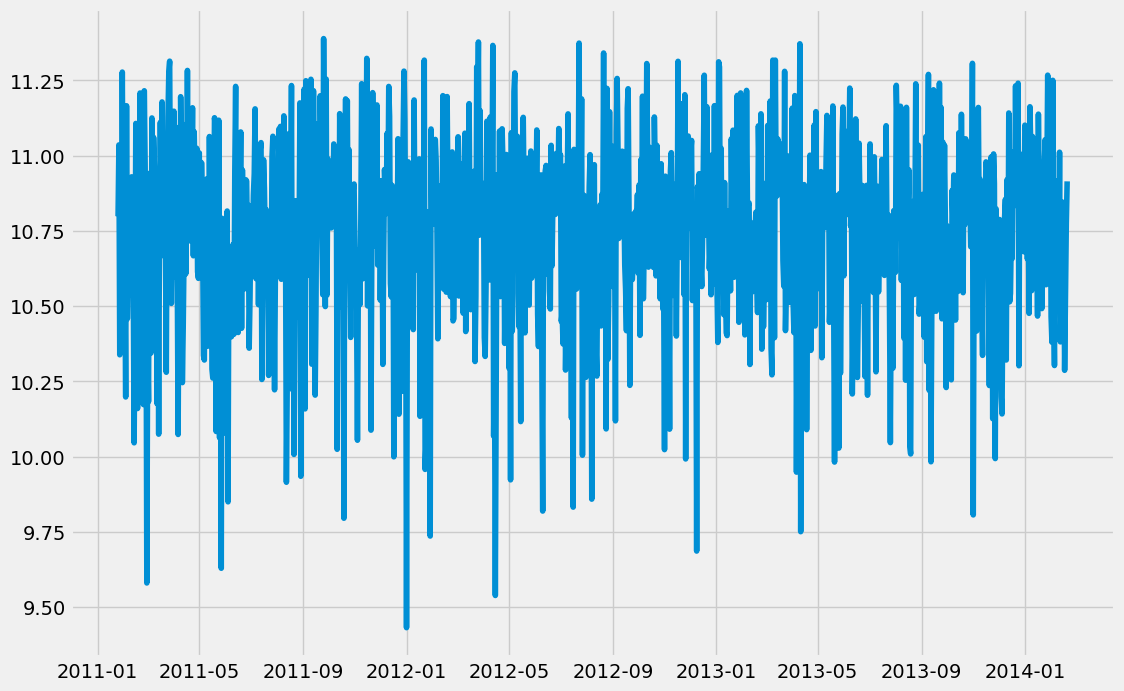

In [46]:
# log transformation
fig, ax = plt.subplots(figsize=(12,8))
ts_log = np.log(df_ts)
plt.plot(ts_log);

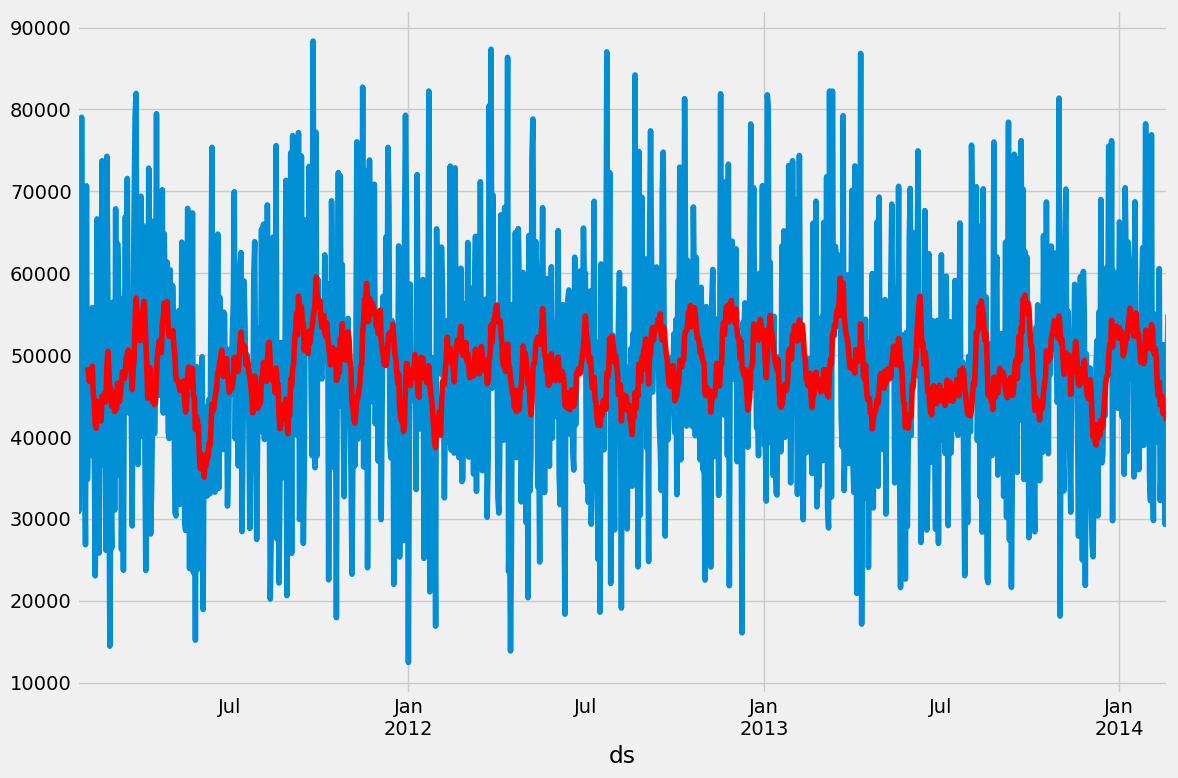

In [47]:
# check the original plot
ma = df_ts.rolling(12).mean()

fig, ax = plt.subplots(figsize=(12,8))
df_ts.plot(ax=ax, legend=False)
ma.plot(ax=ax, color='r', legend=False)
plt.tight_layout();

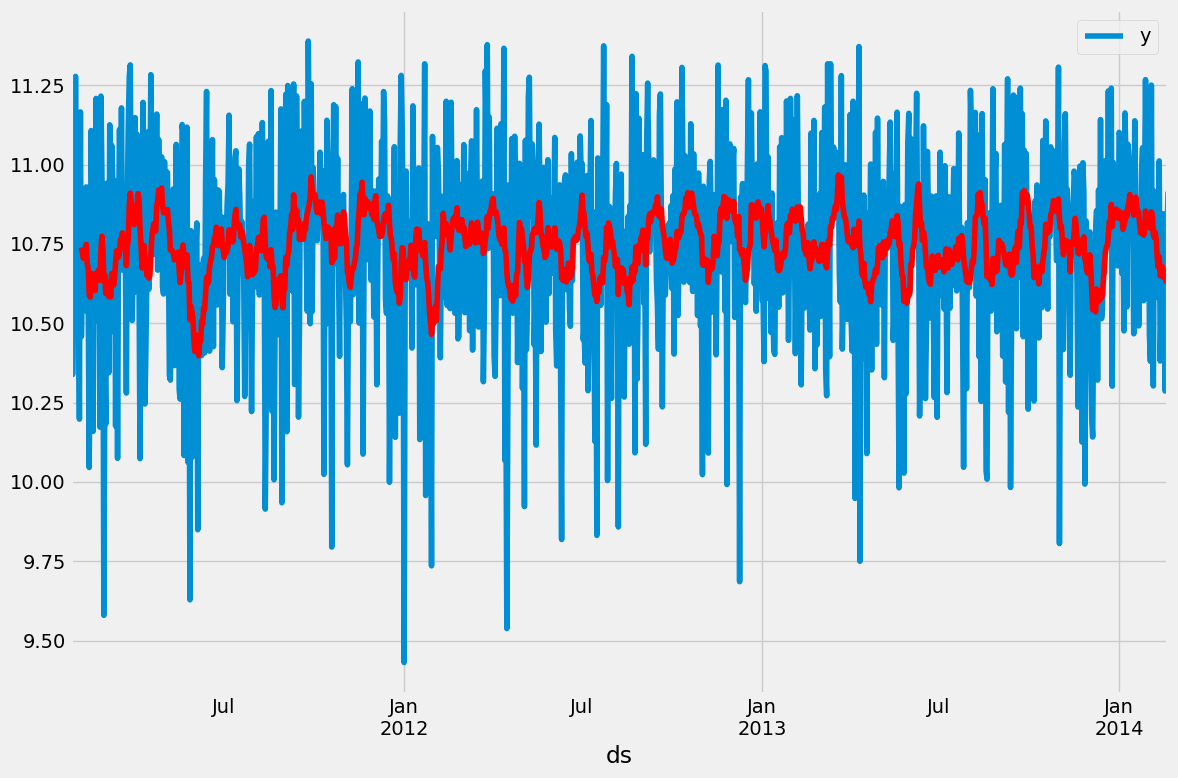

In [49]:
# applying the log
df_log = np.log(df_ts)
ma_log = df_log.rolling(12).mean()

fig, ax = plt.subplots(figsize=(12,8))
df_log.plot(ax=ax, legend=True)
ma_log.plot(ax=ax, color='r', legend=False)
plt.tight_layout()

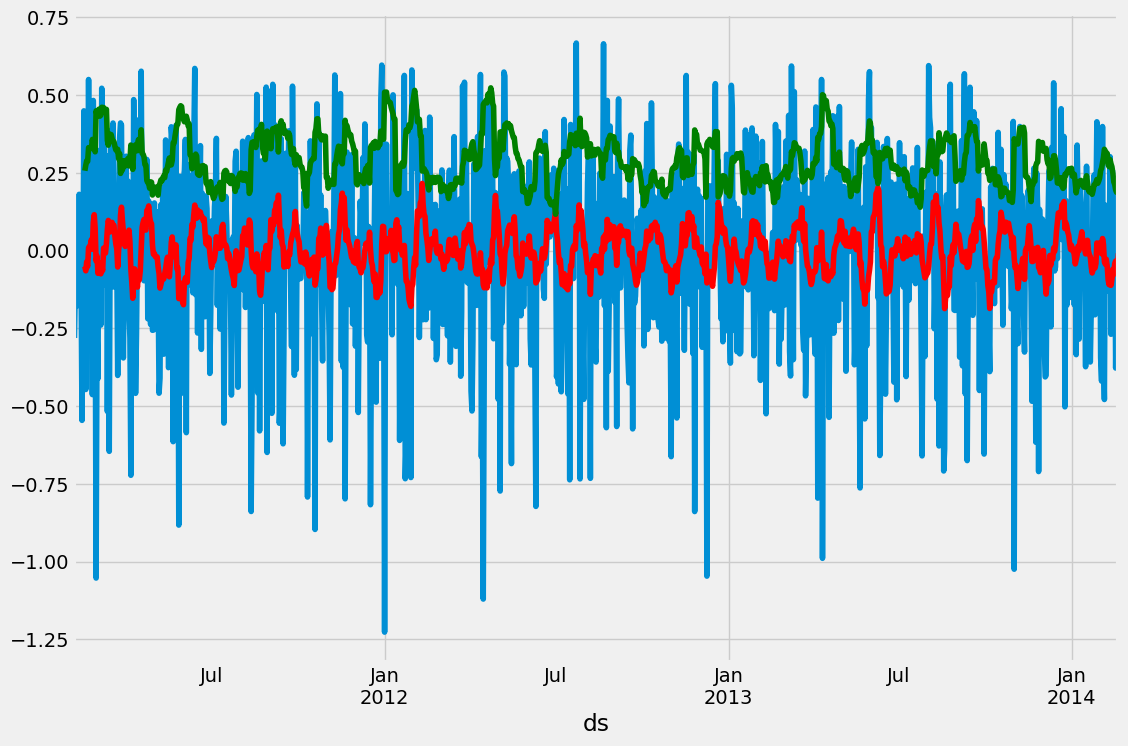

In [50]:
# subtracting the log average from the data
df_sub = (df_log - ma_log).dropna()
ma_sub = df_sub.rolling(12).mean()
std_sub = df_sub.rolling(12).std()

fig, ax = plt.subplots(figsize=(12,8))
df_sub.plot(ax=ax, legend=False)
ma_sub.plot(ax=ax, color='r', legend=False)
std_sub.plot(ax=ax, color='g', legend=False)
plt.show(); 

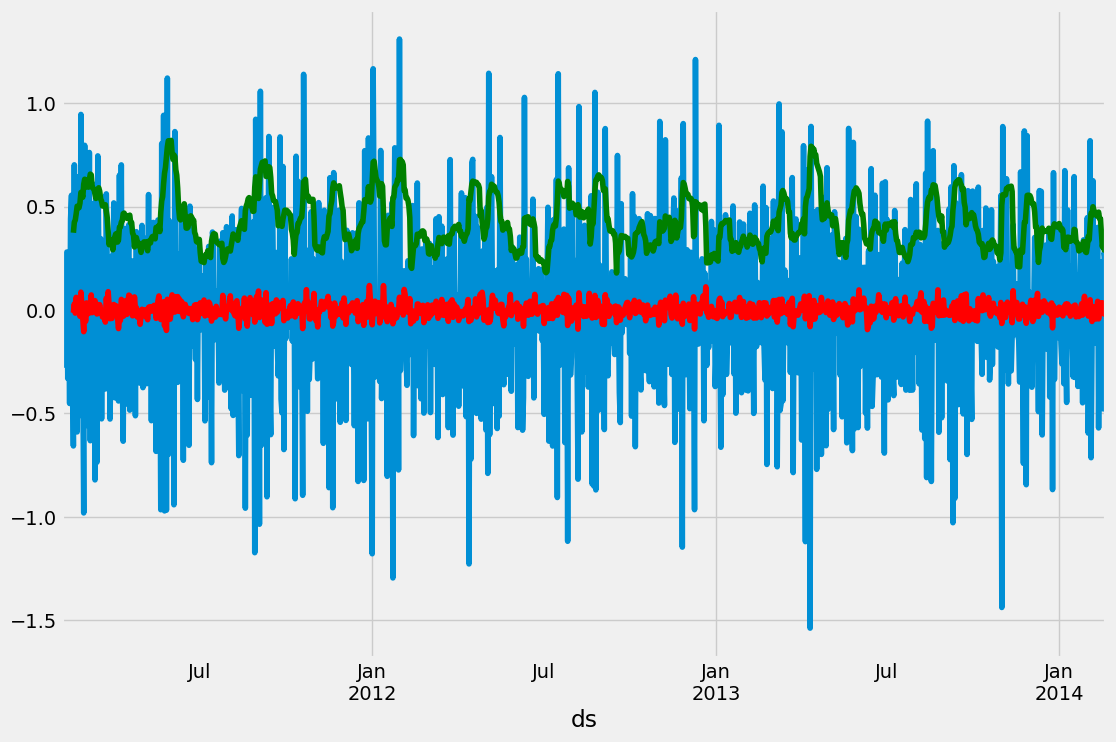

In [51]:
# applying differencing
df_diff = df_sub.diff(1)
ma_diff = df_diff.rolling(12).mean()
std_diff = df_diff.rolling(12).std()

fig, ax = plt.subplots(figsize=(12,8))
df_diff.plot(ax=ax, legend=False)
ma_diff.plot(ax=ax, color='r', legend=False)
std_diff.plot(ax=ax, color='g', legend=False)
plt.show()

# extracting values only
X_diff = df_diff.y.dropna().values




## ii) Working on Stationary Timeseries
Now our timeseries data are stationary. we will work on that

In [52]:
# reset index to come back to Prophet's format
df_log.reset_index(inplace=True)

In [53]:
# setting prediction size to 180
prediction_size = 180
train_df = df_log[:-prediction_size]

In [54]:
# instatiating the model
m = Prophet()

# training the model
m.fit(train_df)

# make predictions
future = m.make_future_dataframe(periods=prediction_size)

forecast = m.predict(future)

forecast.head()

20:39:05 - cmdstanpy - INFO - Chain [1] start processing
20:39:05 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-01-25,10.728590,10.283013,11.054532,10.728590,10.728590,-0.063704,-0.063704,-0.063704,-0.005370,-0.005370,-0.005370,-0.058334,-0.058334,-0.058334,0.0,0.0,0.0,10.664885
1,2011-01-26,10.728630,10.323581,11.100478,10.728630,10.728630,-0.023568,-0.023568,-0.023568,0.028473,0.028473,0.028473,-0.052041,-0.052041,-0.052041,0.0,0.0,0.0,10.705062
2,2011-01-27,10.728671,10.269305,11.072321,10.728671,10.728671,-0.053670,-0.053670,-0.053670,-0.008591,-0.008591,-0.008591,-0.045078,-0.045078,-0.045078,0.0,0.0,0.0,10.675001
3,2011-01-28,10.728712,10.317637,11.093191,10.728712,10.728712,-0.027333,-0.027333,-0.027333,0.010306,0.010306,0.010306,-0.037639,-0.037639,-0.037639,0.0,0.0,0.0,10.701379
4,2011-01-29,10.728752,10.296471,11.121222,10.728752,10.728752,-0.011024,-0.011024,-0.011024,0.018906,0.018906,0.018906,-0.029930,-0.029930,-0.029930,0.0,0.0,0.0,10.717728


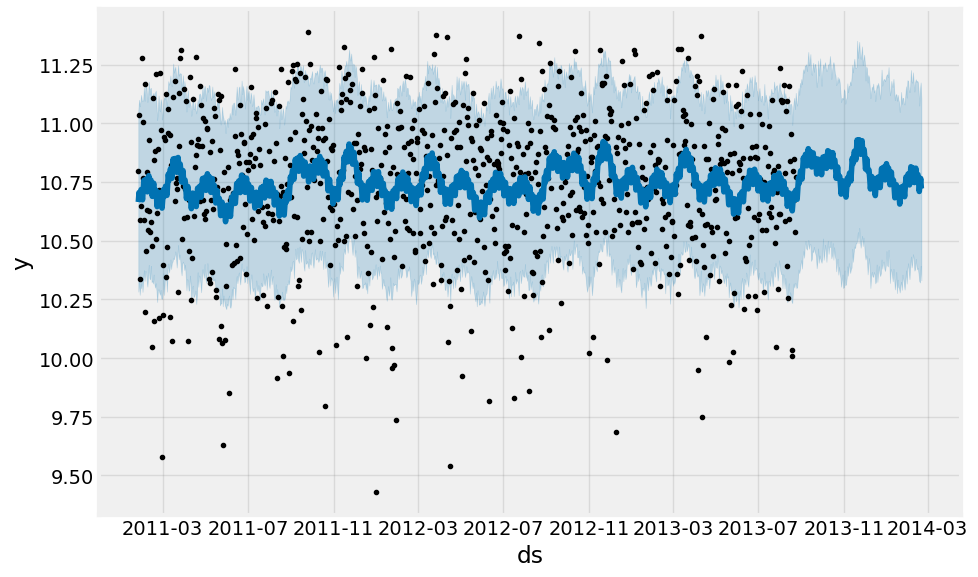

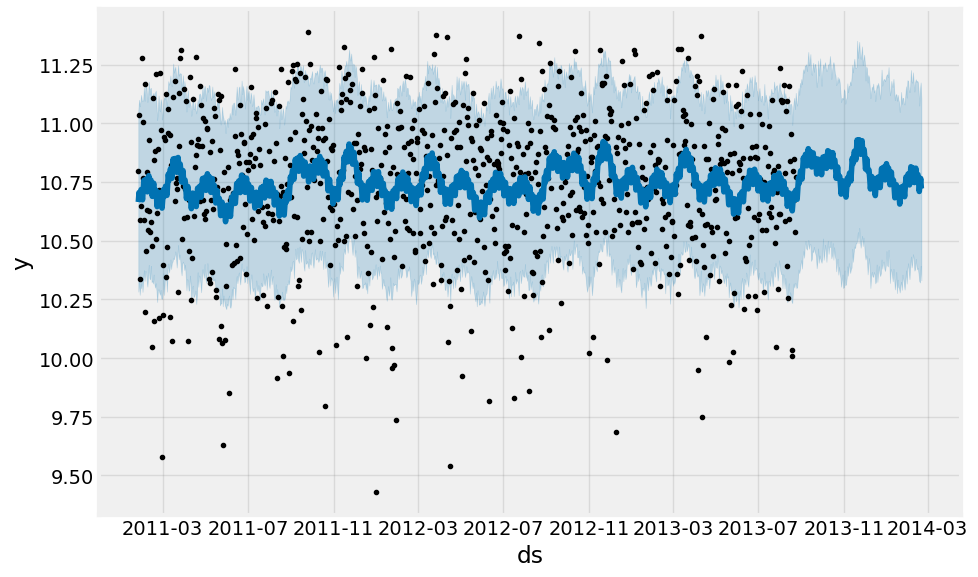

In [55]:
# plotting the forecast
m.plot(forecast) 

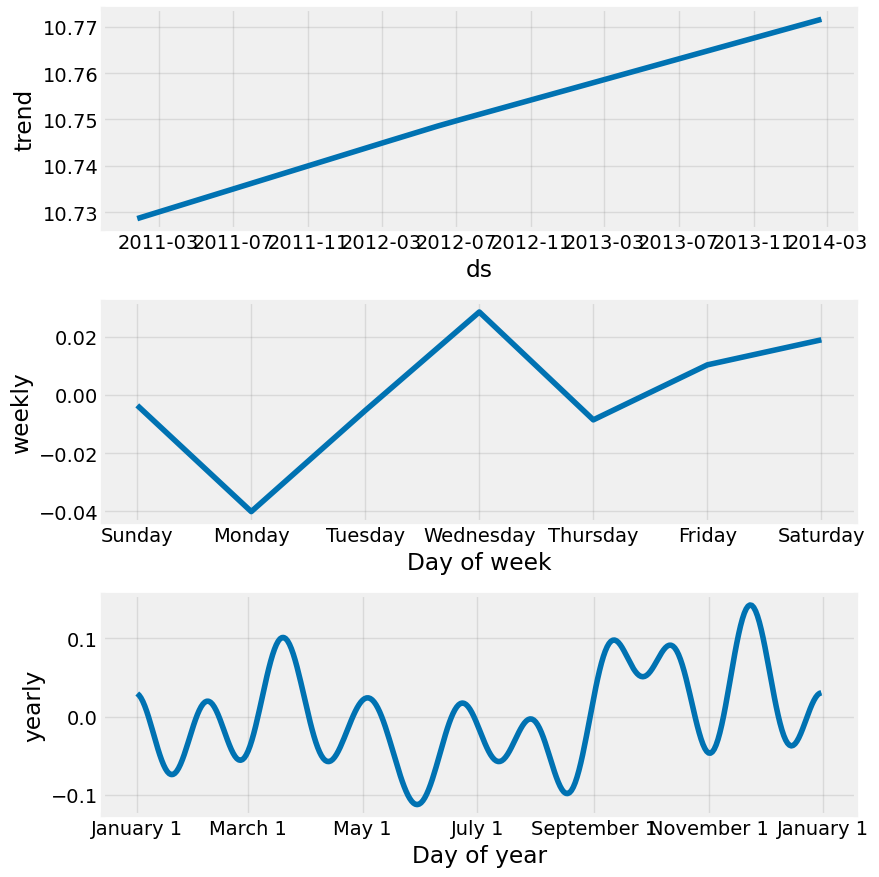

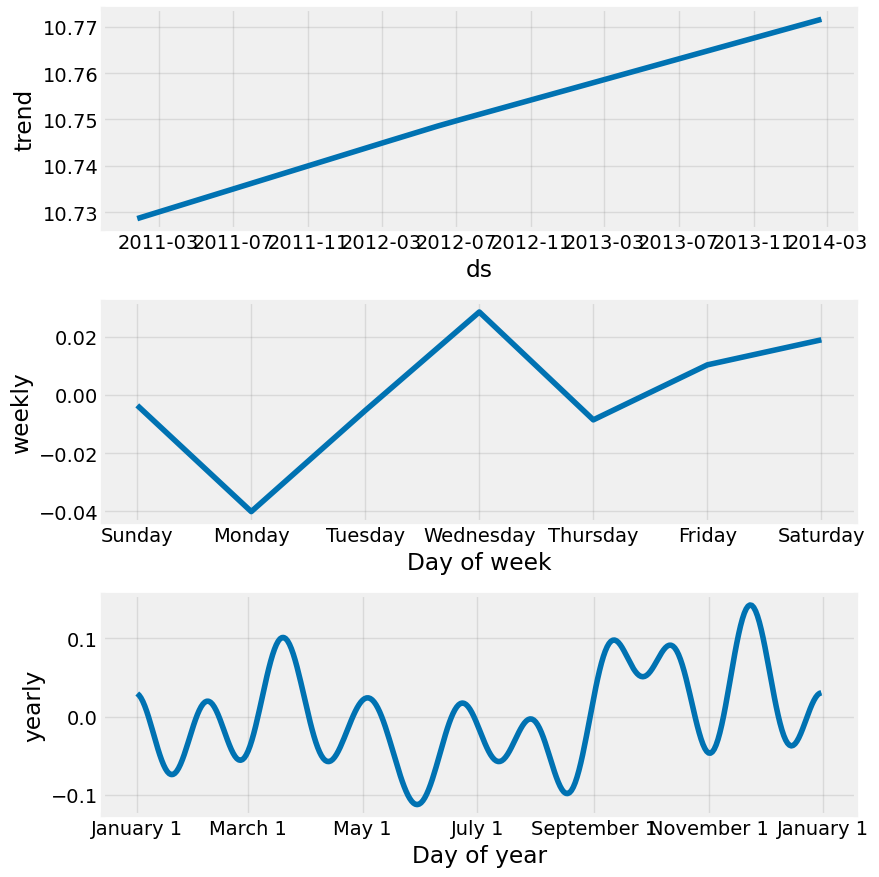

In [56]:
# plotting components
m.plot_components(forecast)

In [57]:
# define a function to make a dataframe containing the predicion and actual values
def make_comparison_dataframe(historical, forecast):
      return forecast.set_index('ds')[['yhat', 'yhat_lower',
                                'yhat_upper']].join(historical.set_index('ds')) 

In [ ]:
# define a function to calculate MAPE and MAE
def calculate_forecast_errors(df_ts, prediction_size):

  df = df_ts.copy()
  df['e'] = df['y'] - df['yhat']
  df['p'] = 100 * df['e'] / df['y']
  predicted_part = df[-prediction_size:]

  error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))

  return{'MAPE': error_mean('p'), 'MAE': error_mean('e')} 